In [1]:
from collections import namedtuple
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, fbeta_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from pipe import select, where, sort

import presentation as p

# reading in relevant data frames

training_df_scaled_enc_le_clean = pd.read_csv('data/training_df_scaled_enc_le_clean.csv', index_col=None)
training_df_enc_le_clean = pd.read_csv('data/training_df_enc_le_clean.csv', index_col=None)
testing_df_scaled_enc_le_clean = pd.read_csv('data/testing_df_scaled_enc_le_clean.csv', index_col=None)
testing_df_enc_le_clean = pd.read_csv('data/testing_df_enc_le_clean.csv', index_col=None)

X_train_is_attack = training_df_scaled_enc_le_clean.drop(['target', 'target_group', 'is_attack'], axis=1)
X_train_attack_group = training_df_enc_le_clean[training_df_enc_le_clean.is_attack].drop(['target', 'target_group', 'is_attack'], axis=1)
y_train_is_attack = training_df_scaled_enc_le_clean.is_attack
y_train_attack_group = training_df_enc_le_clean[training_df_enc_le_clean.is_attack].target_group
X_test_is_attack = testing_df_scaled_enc_le_clean.drop(['target', 'target_group', 'is_attack'], axis=1)
X_test_attack_group = testing_df_enc_le_clean[testing_df_enc_le_clean.is_attack].drop(['target', 'target_group', 'is_attack'], axis=1)
y_true_is_attack = testing_df_scaled_enc_le_clean.is_attack
y_true_attack_group = testing_df_enc_le_clean[testing_df_enc_le_clean.is_attack].target_group

# Metrics
beta = 10
fbeta_average = 'weighted'

def simple_confusion_matrix(y_true, y_pred, target):
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.blues_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.purples_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

hpt_result = namedtuple('HyperparameterTuningResult', ['model', 'best_params', 'best_score', 'accuracy', 'fbeta'])

def evaluate_hpt(model, X_test, y_true, beta=beta, average=fbeta_average, display_false_negatives=True):
    best_params = model.best_params_
    param_string = ''.join((f'\t{key}:\t{value}\n' for key, value in best_params.items()))
    best_score = model.best_score_
    pred = model.predict(X_test)
    acc = accuracy_score(y_true, pred)
    fbeta = fbeta_score(y_true, pred, beta=beta, average=average)
    print('-- Training Results --')
    print(f'Best Parameters:\n{param_string}', end='')
    print(f'Best Score:\n\t{best_score:.6f}')
    print('\n-- Testing Results --')
    print(f'Accuracy    on Verification Data:\t{acc:.6f}')
    print(f'Fbeta scroe on Verification Data:\t{fbeta:.6f}\n')
    print(classification_report(y_true, pred))
    if display_false_negatives:
        total_attacks = y_true.value_counts().iloc[1]
        confusion = confusion_matrix(y_true, pred)
        false_negatives = confusion[1, 0]
        print(f'False negatives: {false_negatives} ({100 * false_negatives / total_attacks:.3f}% out of {total_attacks} attacks, {100 * false_negatives / len(y_true):.3f}% overall)\n')
    return hpt_result(model, best_params, best_score, acc, fbeta)

eval_result = namedtuple('Evaluation', ['model', 'accuracy', 'fbeta'])

def evaluate_model(model, X_test, y_true, beta=beta, average=fbeta_average, display_false_negatives=False):
    pred = model.predict(X_test)
    acc = accuracy_score(y_true, pred)
    fbeta = fbeta_score(y_true, pred, beta=beta, average=average)
    print('\n-- Testing Results --')
    print(f'Accuracy    on Verification Data:\t{acc:.6f}')
    print(f'Fbeta scroe on Verification Data:\t{fbeta:.6f}\n')
    print(classification_report(y_true, pred))
    if display_false_negatives:
        total_attacks = y_true.value_counts().iloc[1]
        confusion = confusion_matrix(y_true, pred)
        false_negatives = confusion[1, 0]
        print(f'False negatives: {false_negatives} ({100 * false_negatives / total_attacks:.3f}% out of {total_attacks} attacks, {100 * false_negatives / len(y_true):.3f}% overall)\n')
    return eval_result(model, acc, fbeta)

def compare_models(new_results, old_results):
    is_improved = new_results.fbeta > old_results.fbeta
    print('-- HPT Evaluation --')
    print(f'{new_results.fbeta - old_results.fbeta = :.6f}', end='')
    print(' --> Improvement!') if is_improved else print(' --> Worsened!')
    print(f'{new_results.accuracy - old_results.accuracy = :.6f}', end='')
    print(' --> Improvement!') if new_results.accuracy > old_results.accuracy else print(' --> Worsened!')

    print(f'\nBest model so far:')
    best_results = new_results if is_improved else old_results
    best_model = f'{best_results.model.estimator} with Parameters\n{best_results.best_params}'
    best_score = new_results.fbeta if is_improved else old_results.fbeta
    print(f'{best_model}\nIts score: {best_score:.6f}')

    return best_model, best_score

## Downsampling

In [2]:
# Original dataset
df_attack = training_df_enc_le_clean[training_df_enc_le_clean.is_attack]
df_attack_scaled = training_df_scaled_enc_le_clean[training_df_scaled_enc_le_clean.is_attack]
df_normal = training_df_enc_le_clean[~training_df_enc_le_clean.is_attack]
df_normal_scaled = training_df_scaled_enc_le_clean[~training_df_scaled_enc_le_clean.is_attack]

# Downsampling
n = len(df_attack)
df_normal_down, df_normal_scaled_down = resample(df_normal, df_normal_scaled, n_samples=n, random_state=404)

# Combining attack and reduced genuine datasets into one
training_df_down = pd.concat([df_attack, df_normal_down], axis=0)
training_df_scaled_down = pd.concat([df_attack_scaled, df_normal_scaled_down], axis=0)

--------------------------------------------------------------------------------

# Metrics and Reduced Datasets for HPT

In [3]:
# Finding the best model
BEST_MODEL_IS_ATTACK = None
BEST_SCORE_IS_ATTACK = None
BEST_MODEL_ATTACK_GROUP = None
BEST_SCORE_ATTACK_GROUP = None

In [4]:
# Selecting subsets of the data according to their importance for the models

feature_imp_is_attack = {
    'same_srv_rate': 0.21199866684770505,
    'count': 0.1385794555921013,
    'diff_srv_rate': 0.11660354574720663,
    'src_bytes': 0.07133604504271888,
    'flag': 0.0689813541719748,
    'dst_host_srv_serror_rate': 0.0621598020912925,
    'dst_bytes': 0.057168688956664895,
    'dst_host_same_srv_rate': 0.05254858459557669,
    'srv_serror_rate': 0.04469331875735019,
    'serror_rate': 0.04097324469080398,
    'service': 0.01868051080047695,
    'dst_host_serror_rate': 0.01802081827734208,
    'dst_host_srv_count': 0.011545183650792126,
    'dst_host_same_src_port_rate': 0.011337335403034117,
    'protocol_type': 0.01111283067949643,
    'srv_count': 0.009167672319969513,
    'dst_host_count': 0.00873490361773566,
    'dst_host_srv_rerror_rate': 0.008354143406230159,
    'dst_host_diff_srv_rate': 0.007982036329319523,
    'logged_in': 0.007096409133012435,
    'dst_host_srv_diff_host_rate': 0.006912055417103559,
    'dst_host_rerror_rate': 0.0048513483664072345,
    'rerror_rate': 0.0025784179881967813,
    'wrong_fragment': 0.0020432908004560796,
    'srv_rerror_rate': 0.0016133665984154693,
    'num_compromised': 0.001456082442758954,
    'duration': 0.0013066127485688805,
    'hot': 0.0012589559107352938,
    'srv_diff_host_rate': 0.0006086465735149157,
    'is_guest_login': 0.00013464784144864953,
    'num_root': 4.6925733316063196e-05,
    'num_failed_logins': 4.487859382061017e-05,
    'num_file_creations': 2.0557845839487765e-05,
    'root_shell': 1.7416012225572053e-05,
    'num_access_files': 1.2171215578937403e-05,
    'num_shells': 8.344719212122783e-06,
    'urgent': 4.825536792287678e-06,
    'land': 4.449872331211087e-06,
    'su_attempted': 2.354686052141186e-06,
    'is_host_login': 1.0098642182210754e-07,
    'num_outbound_cmds': 0.0,
}
feature_imp_attack_group = {
    'count': 0.11920650442888907,
    'same_srv_rate': 0.10508972465410206,
    'diff_srv_rate': 0.08778113217680307,
    'serror_rate': 0.06974624054103938,
    'src_bytes': 0.0640681281401352,
    'dst_host_serror_rate': 0.06197018656697434,
    'dst_host_srv_serror_rate': 0.049256820180968386,
    'flag': 0.0491294984749818,
    'srv_serror_rate': 0.04423081413644857,
    'dst_host_srv_count': 0.03069288273419006,
    'dst_host_same_srv_rate': 0.020759103385937262,
    'dst_host_diff_srv_rate': 0.01598050573983522,
    'logged_in': 0.011148092661821485,
    'dst_host_same_src_port_rate': 0.010252432103140747,
    'dst_host_rerror_rate': 0.009870914010633081,
    'dst_bytes': 0.008271947585178354,
    'service': 0.007529789663669806,
    'dst_host_srv_diff_host_rate': 0.006014249598252015,
    'srv_count': 0.005338970005448468,
    'protocol_type': 0.004343821344787647,
    'dst_host_count': 0.003041925901452739,
    'dst_host_srv_rerror_rate': 0.0023676962473431987,
    'rerror_rate': 0.0022699746770110697,
    'srv_rerror_rate': 0.002078234928357929,
    'wrong_fragment': 0.0010900818924401603,
    'duration': 0.0007935300753938383,
    'srv_diff_host_rate': 0.0007000191956692632,
    'num_compromised': 0.0005603127418954962,
    'hot': 0.0005271824283889686,
    'is_guest_login': 0.00014356022382561943,
    'num_failed_logins': 3.086911390714573e-05,
    'num_root': 1.5834502309349034e-05,
    'root_shell': 1.3788709019323287e-05,
    'num_file_creations': 1.3195338230340304e-05,
    'land': 7.80724860591366e-06,
    'num_access_files': 4.715672181492601e-06,
    'num_shells': 2.8059963938124785e-06,
    'urgent': 1.687193322355405e-06,
    'su_attempted': 6.923677716956813e-07,
    'num_outbound_cmds': 0.0,
    'is_host_login': 0.0,
}
def feature(ranking): return ranking[0]
def importance(ranking): return ranking[1]
def top_n_features(n, features):
    return list(
        list(features.items())
        | sort(importance, reverse=True)
        | select(feature)
    )[:n]
def features_above(threshold, features):
    return list(
        list(features.items())
        | where(lambda feature: importance(feature) >= threshold)
        | select(feature)
    )

In [5]:
# For HPT, we will restrict ourselves to the top 15 respective most important features.
top_features_is_attack = top_n_features(15, feature_imp_is_attack)
top_features_attack_group = top_n_features(15, feature_imp_attack_group)

In [6]:
# Attack Detection
X_train_is_attack = training_df_down[top_features_is_attack]
y_train_is_attack = training_df_down.is_attack
X_test_is_attack = testing_df_enc_le_clean[top_features_is_attack]
y_true_is_attack = testing_df_enc_le_clean.is_attack

# Attack Classification
X_train_attack_group = training_df_down[training_df_down.is_attack][top_features_attack_group]
y_train_attack_group = training_df_down[training_df_down.is_attack].target_group
X_test_attack_group = testing_df_enc_le_clean[testing_df_enc_le_clean.is_attack][top_features_attack_group]
y_true_attack_group = testing_df_enc_le_clean[testing_df_enc_le_clean.is_attack].target_group

In [ ]:
beta = 10
fbeta_average = 'weighted'
accuracy_scorer = make_scorer(accuracy_score)
f10_scorer = make_scorer(fbeta_score, beta=beta, average=fbeta_average)

def hyperparameter_tuning(parameter_grid, base_estimator, X_train, y_train, scoring, refit=True, verbose=3):
    return GridSearchCV(estimator=base_estimator, param_grid=parameter_grid, refit=refit, verbose=verbose, scoring=scoring).fit(X_train, y_train)

--------------------------------------------------------------------------------

# Random Forest Classification

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
rf_param_grid = {
    'n_estimators': [20, 50, 100, 150],             # number of trees
    'max_depth': [5, 10, 20, 40, 60, None],         # maximum tree size (number of decisions)
    'criterion': ['gini', 'entropy', 'log_loss'],   # split criterion
    'n_jobs': [-1],                                 # number of parallel jobs; use all available cores
    'random_state': [404],                          # for reproducibility
}

In [13]:
rf_is_attack_grid_search = hyperparameter_tuning(
    parameter_grid=rf_param_grid,
    base_estimator=RandomForestClassifier(),
    X_train=X_train_is_attack,
    y_train=y_train_is_attack,
    scoring=f10_scorer
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.987 total time=   0.5s
[CV 2/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.981 total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=1.000 total time=   0.5s
[CV 4/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.999 total time=   0.5s
[CV 5/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.997 total time=   0.5s
[CV 1/5] END criterion=gini, max_depth=5, n_estimators=50, n_jobs=-1, random_state=404;, score=0.985 total time=   1.0s
[CV 2/5] END criterion=gini, max_depth=5, n_estimators=50, n_jobs=-1, random_state=404;, score=0.982 total time=   1.0s
[CV 3/5] END criterion=gini, max_depth=5, n_estimators=50, n_jobs=-1, random_state=404;, score=0.9

In [14]:
rf_attack_group_grid_search = hyperparameter_tuning(
    parameter_grid=rf_param_grid,
    base_estimator=RandomForestClassifier(),
    X_train=X_train_attack_group,
    y_train=y_train_attack_group,
    scoring=accuracy_scorer
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.984 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.999 total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.999 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.994 total time=   0.3s
[CV 5/5] END criterion=gini, max_depth=5, n_estimators=20, n_jobs=-1, random_state=404;, score=0.236 total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=5, n_estimators=50, n_jobs=-1, random_state=404;, score=0.985 total time=   0.6s
[CV 2/5] END criterion=gini, max_depth=5, n_estimators=50, n_jobs=-1, random_state=404;, score=0.999 total time=   0.5s
[CV 3/5] END criterion=gini, max_depth=5, n_estimators=50, n_jobs=-1, random_state=404;, score=0.9

In [15]:
rf_result_is_attack = evaluate_hpt(
    model=rf_is_attack_grid_search,
    X_test=X_test_is_attack,
    y_true=y_true_is_attack
)

-- Training Results --
Best Parameters:
	criterion:	gini
	max_depth:	40
	n_estimators:	50
	n_jobs:	-1
	random_state:	404
Best Score:
	0.996918

-- Testing Results --
Accuracy    on Verification Data:	0.937755
Fbeta scroe on Verification Data:	0.937680

              precision    recall  f1-score   support

       False       0.91      0.99      0.95     47913
        True       0.99      0.85      0.91     29378

    accuracy                           0.94     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.94      0.94     77291

False negatives: 4460 (15.181% out of 29378 attacks, 5.770% overall)



In [16]:
_ = evaluate_hpt(
    model=rf_is_attack_grid_search,
    X_test=X_test_is_attack,
    y_true=y_true_is_attack,
    average='binary'
)

-- Training Results --
Best Parameters:
	criterion:	gini
	max_depth:	40
	n_estimators:	50
	n_jobs:	-1
	random_state:	404
Best Score:
	0.996918

-- Testing Results --
Accuracy    on Verification Data:	0.937755
Fbeta scroe on Verification Data:	0.849362

              precision    recall  f1-score   support

       False       0.91      0.99      0.95     47913
        True       0.99      0.85      0.91     29378

    accuracy                           0.94     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.94      0.94     77291

False negatives: 4460 (15.181% out of 29378 attacks, 5.770% overall)



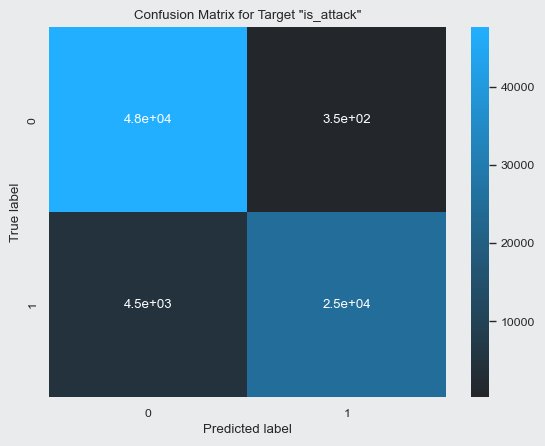

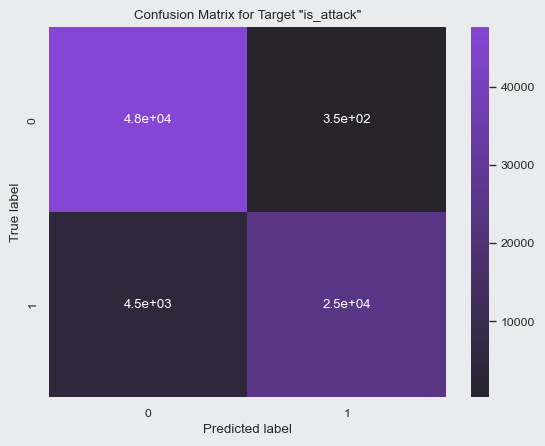

In [18]:
rf_is_attack_pred = rf_is_attack_grid_search.predict(X_test_is_attack)
simple_confusion_matrix(y_true_is_attack, rf_is_attack_pred, 'is_attack')

In [19]:
rf_result_attack_group = evaluate_hpt(
    model=rf_attack_group_grid_search,
    X_test=X_test_attack_group,
    y_true=y_true_attack_group
)

-- Training Results --
Best Parameters:
	criterion:	gini
	max_depth:	20
	n_estimators:	20
	n_jobs:	-1
	random_state:	404
Best Score:
	0.844451

-- Testing Results --
Accuracy    on Verification Data:	0.906767
Fbeta scroe on Verification Data:	0.906661

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     23747
           2       0.62      0.82      0.70      3041
           3       0.82      0.50      0.62      2533
           4       0.14      0.16      0.15        57

    accuracy                           0.91     29378
   macro avg       0.64      0.61      0.61     29378
weighted avg       0.91      0.91      0.91     29378

False negatives: 529 (17.396% out of 3041 attacks, 1.801% overall)



In [20]:
rf_result_attack_group = evaluate_hpt(
    model=rf_attack_group_grid_search,
    X_test=X_test_attack_group,
    y_true=y_true_attack_group,
    average='macro'
)

-- Training Results --
Best Parameters:
	criterion:	gini
	max_depth:	20
	n_estimators:	20
	n_jobs:	-1
	random_state:	404
Best Score:
	0.844451

-- Testing Results --
Accuracy    on Verification Data:	0.906767
Fbeta scroe on Verification Data:	0.610170

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     23747
           2       0.62      0.82      0.70      3041
           3       0.82      0.50      0.62      2533
           4       0.14      0.16      0.15        57

    accuracy                           0.91     29378
   macro avg       0.64      0.61      0.61     29378
weighted avg       0.91      0.91      0.91     29378

False negatives: 529 (17.396% out of 3041 attacks, 1.801% overall)



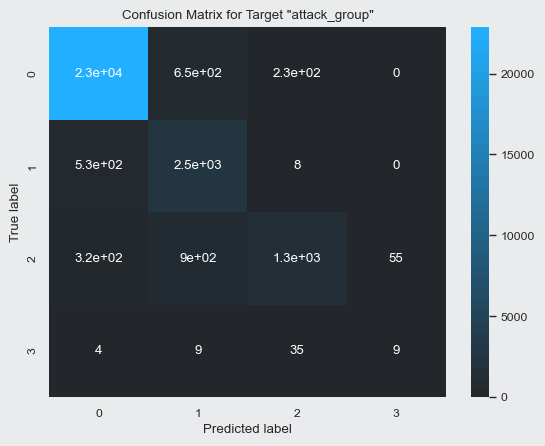

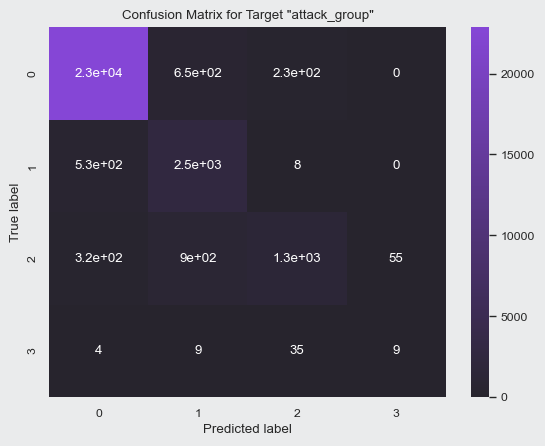

In [22]:
rf_attack_group_pred = rf_attack_group_grid_search.predict(X_test_attack_group)
simple_confusion_matrix(y_true_attack_group, rf_attack_group_pred, 'attack_group')

In [23]:
BEST_MODEL_IS_ATTACK, BEST_SCORE_IS_ATTACK = compare_models(rf_result_is_attack, rf_result_is_attack)
print()
BEST_MODEL_ATTACK_GROUP, BEST_SCORE_ATTACK_GROUP = compare_models(rf_result_attack_group, rf_result_attack_group)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
RandomForestClassifier() with Parameters
{'criterion': 'gini', 'max_depth': 40, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 404}
Its score: 0.937680

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = 0.000000 --> Worsened!
new_results.accuracy - old_results.accuracy = 0.000000 --> Worsened!

Best model so far:
RandomForestClassifier() with Parameters
{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 404}
Its score: 0.610170



-- Testing Results --
Accuracy    on Verification Data:	0.937755
Fbeta scroe on Verification Data:	0.849362

              precision    recall  f1-score   support

       False       0.91      0.99      0.95     47913
        True       0.99      0.85      0.91     29378

    accuracy                           0.94     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.94      0.94     77291



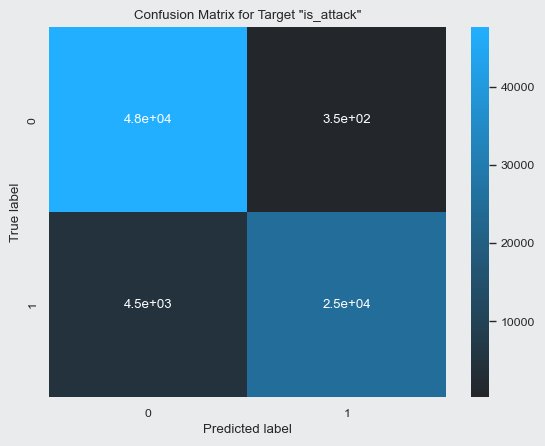

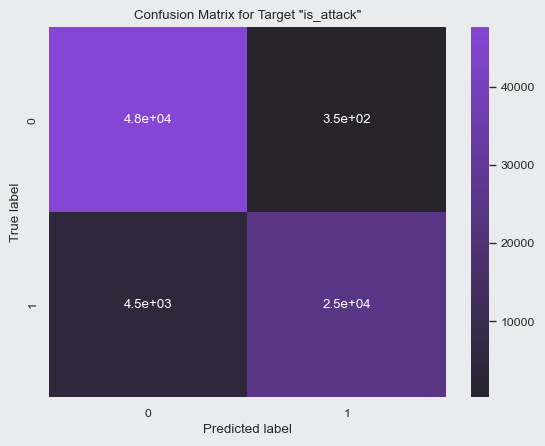

In [58]:
# Best model on the whole dataset (Attack Detection)
best_rf_is_attack = rf_is_attack_grid_search.best_estimator_.fit(X_train_is_attack, y_train_is_attack)
evaluate_model(best_rf_is_attack, X_test_is_attack, y_true_is_attack, beta=beta, average='binary')
best_rf_is_attack_pred = best_rf_is_attack.predict(X_test_is_attack)
simple_confusion_matrix(y_true_is_attack, best_rf_is_attack_pred, 'is_attack')


-- Testing Results --
Accuracy    on Verification Data:	0.906767
Fbeta scroe on Verification Data:	0.610170

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     23747
           2       0.62      0.82      0.70      3041
           3       0.82      0.50      0.62      2533
           4       0.14      0.16      0.15        57

    accuracy                           0.91     29378
   macro avg       0.64      0.61      0.61     29378
weighted avg       0.91      0.91      0.91     29378



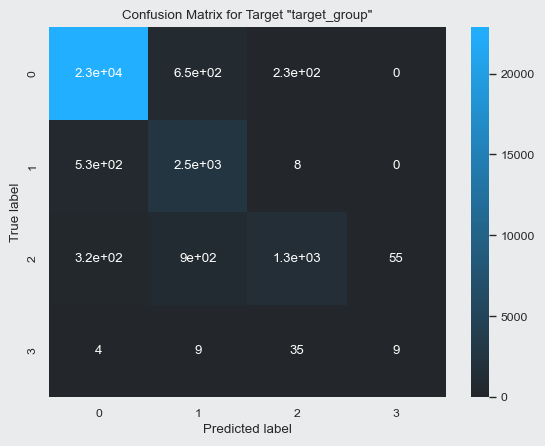

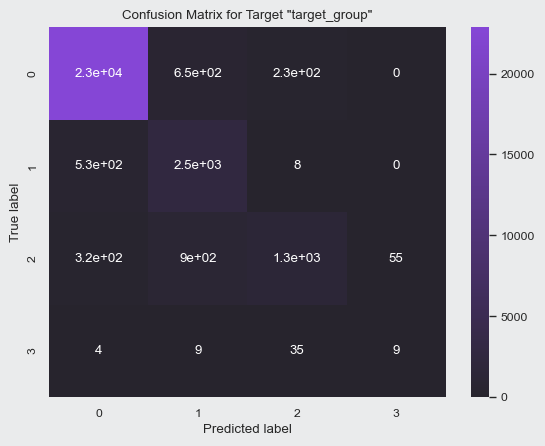

In [59]:
# Best model on the whole dataset (Attack Classification)
best_rf_attack_group = rf_attack_group_grid_search.best_estimator_.fit(X_train_attack_group, y_train_attack_group)
evaluate_model(best_rf_attack_group, X_test_attack_group, y_true_attack_group, beta=beta, average='macro')
best_rf_attack_group_pred = best_rf_attack_group.predict(X_test_attack_group)
simple_confusion_matrix(y_true_attack_group, best_rf_attack_group_pred, 'target_group')

--------------------------------------------------------------------------------

# AdaBoost Classification

In [7]:
from sklearn.ensemble import AdaBoostClassifier

In [8]:
ab_param_grid = {
    'n_estimators': [10, 20, 50, 100],              # number of trees
    'learning_rate': [.5 + .2*n for n in range(6)], # learning rate
    'algorithm': ['SAMME'],                         # SAMME.R is deprecated
    'random_state': [404],                          # for reproducibility
}

In [18]:
ab_is_attack_grid_search = hyperparameter_tuning(
    parameter_grid=ab_param_grid,
    base_estimator=AdaBoostClassifier(),
    X_train=X_train_is_attack,
    y_train=y_train_is_attack,
    scoring=f10_scorer
)# 11m 5.6s

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END algorithm=SAMME, learning_rate=0.5, n_estimators=10, random_state=404;, score=0.957 total time=   1.3s
[CV 2/5] END algorithm=SAMME, learning_rate=0.5, n_estimators=10, random_state=404;, score=0.947 total time=   1.2s
[CV 3/5] END algorithm=SAMME, learning_rate=0.5, n_estimators=10, random_state=404;, score=0.997 total time=   1.3s
[CV 4/5] END algorithm=SAMME, learning_rate=0.5, n_estimators=10, random_state=404;, score=0.959 total time=   1.2s
[CV 5/5] END algorithm=SAMME, learning_rate=0.5, n_estimators=10, random_state=404;, score=0.981 total time=   1.2s
[CV 1/5] END algorithm=SAMME, learning_rate=0.5, n_estimators=20, random_state=404;, score=0.966 total time=   2.4s
[CV 2/5] END algorithm=SAMME, learning_rate=0.5, n_estimators=20, random_state=404;, score=0.946 total time=   2.4s
[CV 3/5] END algorithm=SAMME, learning_rate=0.5, n_estimators=20, random_state=404;, score=0.997 total time=   2.5s
[CV 4/5] E

In [19]:
ab_attack_group_grid_search = hyperparameter_tuning(
    parameter_grid=ab_param_grid,
    base_estimator=AdaBoostClassifier(),
    X_train=X_train_attack_group,
    y_train=y_train_attack_group,
    scoring=accuracy_scorer
)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END algorithm=SAMME, learning_rate=0.5, n_estimators=10, random_state=404;, score=0.980 total time=   0.5s
[CV 2/5] END algorithm=SAMME, learning_rate=0.5, n_estimators=10, random_state=404;, score=0.976 total time=   0.5s
[CV 3/5] END algorithm=SAMME, learning_rate=0.5, n_estimators=10, random_state=404;, score=0.958 total time=   0.5s
[CV 4/5] END algorithm=SAMME, learning_rate=0.5, n_estimators=10, random_state=404;, score=0.982 total time=   0.5s
[CV 5/5] END algorithm=SAMME, learning_rate=0.5, n_estimators=10, random_state=404;, score=0.995 total time=   0.5s
[CV 1/5] END algorithm=SAMME, learning_rate=0.5, n_estimators=20, random_state=404;, score=0.979 total time=   1.1s
[CV 2/5] END algorithm=SAMME, learning_rate=0.5, n_estimators=20, random_state=404;, score=0.981 total time=   1.1s
[CV 3/5] END algorithm=SAMME, learning_rate=0.5, n_estimators=20, random_state=404;, score=0.961 total time=   1.0s
[CV 4/5] E

In [20]:
ab_result_is_attack = evaluate_hpt(
    model=ab_is_attack_grid_search,
    X_test=X_test_is_attack,
    y_true=y_true_is_attack
)

-- Training Results --
Best Parameters:
	algorithm:	SAMME
	learning_rate:	1.5
	n_estimators:	100
	random_state:	404
Best Score:
	0.994822

-- Testing Results --
Accuracy    on Verification Data:	0.937082
Fbeta scroe on Verification Data:	0.937007

              precision    recall  f1-score   support

       False       0.91      0.99      0.95     47913
        True       0.99      0.85      0.91     29378

    accuracy                           0.94     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.94      0.94     77291

False negatives: 4489 (15.280% out of 29378 attacks, 5.808% overall)



In [21]:
_ = evaluate_hpt(
    model=ab_is_attack_grid_search,
    X_test=X_test_is_attack,
    y_true=y_true_is_attack,
    average='binary'
)

-- Training Results --
Best Parameters:
	algorithm:	SAMME
	learning_rate:	1.5
	n_estimators:	100
	random_state:	404
Best Score:
	0.994822

-- Testing Results --
Accuracy    on Verification Data:	0.937082
Fbeta scroe on Verification Data:	0.848375

              precision    recall  f1-score   support

       False       0.91      0.99      0.95     47913
        True       0.99      0.85      0.91     29378

    accuracy                           0.94     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.94      0.94     77291

False negatives: 4489 (15.280% out of 29378 attacks, 5.808% overall)



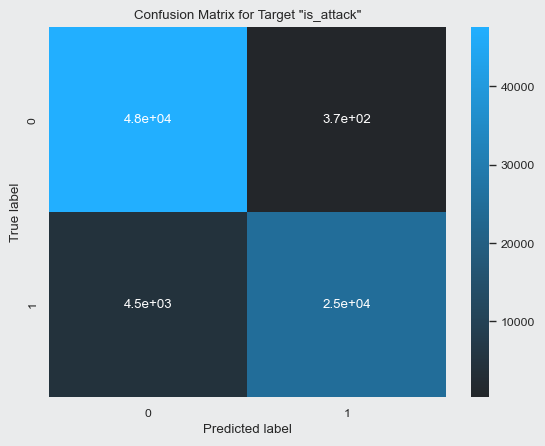

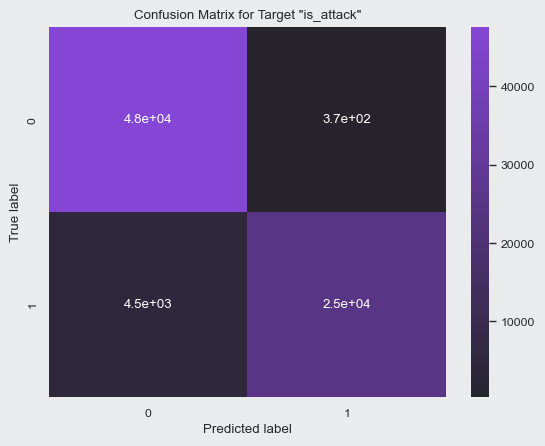

In [22]:
ab_is_attack_pred = ab_is_attack_grid_search.predict(X_test_is_attack)
simple_confusion_matrix(y_true_is_attack, ab_is_attack_pred, 'is_attack')

In [23]:
ab_result_attack_group = evaluate_hpt(
    model=ab_attack_group_grid_search,
    X_test=X_test_attack_group,
    y_true=y_true_attack_group
)

-- Training Results --
Best Parameters:
	algorithm:	SAMME
	learning_rate:	0.7
	n_estimators:	20
	random_state:	404
Best Score:
	0.990014

-- Testing Results --
Accuracy    on Verification Data:	0.883791
Fbeta scroe on Verification Data:	0.883544

              precision    recall  f1-score   support

           0       0.93      0.97      0.94     23747
           2       0.57      0.66      0.61      3041
           3       0.97      0.40      0.57      2533
           4       0.00      0.00      0.00        57

    accuracy                           0.88     29378
   macro avg       0.62      0.51      0.53     29378
weighted avg       0.89      0.88      0.88     29378

False negatives: 1022 (33.607% out of 3041 attacks, 3.479% overall)



/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [24]:
ab_result_attack_group = evaluate_hpt(
    model=ab_attack_group_grid_search,
    X_test=X_test_attack_group,
    y_true=y_true_attack_group,
    average='macro'
)

-- Training Results --
Best Parameters:
	algorithm:	SAMME
	learning_rate:	0.7
	n_estimators:	20
	random_state:	404
Best Score:
	0.990014

-- Testing Results --
Accuracy    on Verification Data:	0.883791
Fbeta scroe on Verification Data:	0.507835

              precision    recall  f1-score   support

           0       0.93      0.97      0.94     23747
           2       0.57      0.66      0.61      3041
           3       0.97      0.40      0.57      2533
           4       0.00      0.00      0.00        57

    accuracy                           0.88     29378
   macro avg       0.62      0.51      0.53     29378
weighted avg       0.89      0.88      0.88     29378

False negatives: 1022 (33.607% out of 3041 attacks, 3.479% overall)



/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

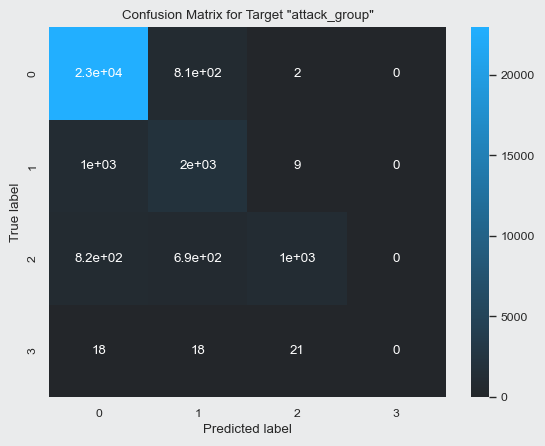

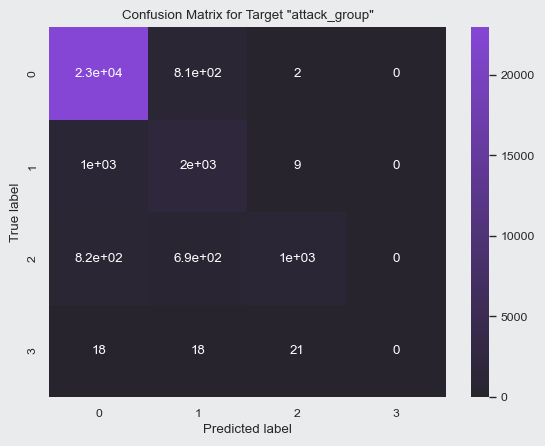

In [25]:
ab_attack_group_pred = ab_attack_group_grid_search.predict(X_test_attack_group)
simple_confusion_matrix(y_true_attack_group, ab_attack_group_pred, 'attack_group')

In [56]:
BEST_MODEL_IS_ATTACK, BEST_SCORE_IS_ATTACK = compare_models(ab_result_is_attack, rf_result_is_attack)
print()
BEST_MODEL_ATTACK_GROUP, BEST_SCORE_ATTACK_GROUP = compare_models(ab_result_attack_group, rf_result_attack_group)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.000673 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.000673 --> Worsened!

Best model so far:
RandomForestClassifier() with Parameters
{'criterion': 'gini', 'max_depth': 40, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 404}
Its score: 0.937680

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.102335 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.022976 --> Worsened!

Best model so far:
RandomForestClassifier() with Parameters
{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 404}
Its score: 0.610170



-- Testing Results --
Accuracy    on Verification Data:	0.937082
Fbeta scroe on Verification Data:	0.848375

              precision    recall  f1-score   support

       False       0.91      0.99      0.95     47913
        True       0.99      0.85      0.91     29378

    accuracy                           0.94     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.94      0.94     77291



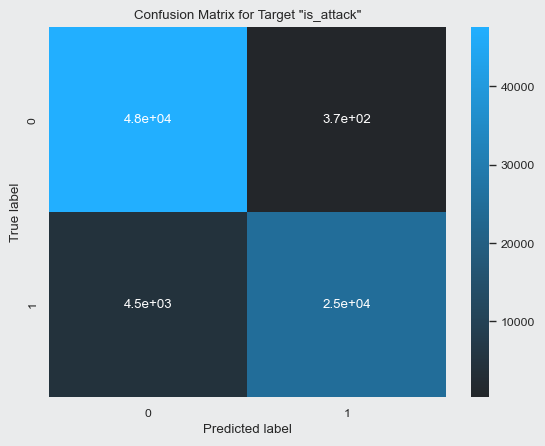

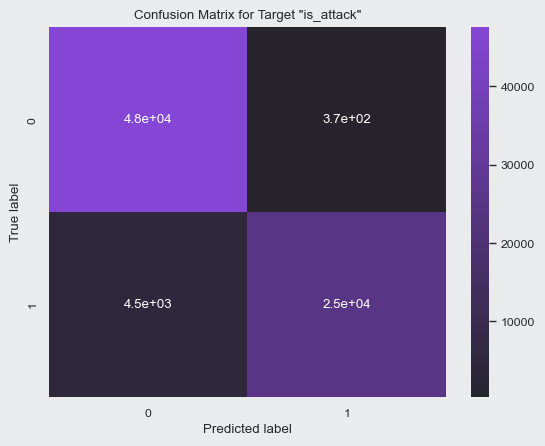

In [26]:
# Best model on the whole dataset (Attack Detection)
best_ab_is_attack = ab_is_attack_grid_search.best_estimator_.fit(X_train_is_attack, y_train_is_attack)
evaluate_model(best_ab_is_attack, X_test_is_attack, y_true_is_attack, beta=beta, average='binary')
best_ab_is_attack_pred = best_ab_is_attack.predict(X_test_is_attack)
simple_confusion_matrix(y_true_is_attack, best_ab_is_attack_pred, 'is_attack')


-- Testing Results --
Accuracy    on Verification Data:	0.883791
Fbeta scroe on Verification Data:	0.507835

              precision    recall  f1-score   support

           0       0.93      0.97      0.94     23747
           2       0.57      0.66      0.61      3041
           3       0.97      0.40      0.57      2533
           4       0.00      0.00      0.00        57

    accuracy                           0.88     29378
   macro avg       0.62      0.51      0.53     29378
weighted avg       0.89      0.88      0.88     29378



/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

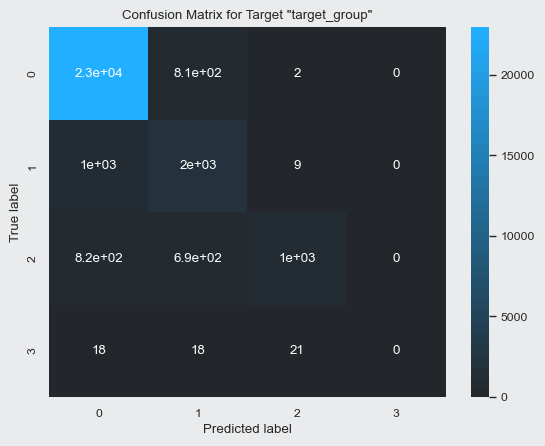

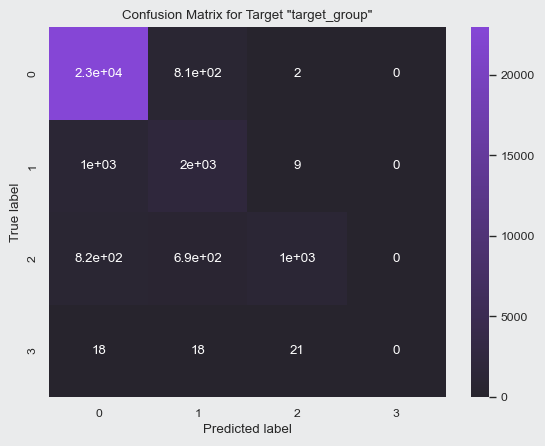

In [27]:
# Best model on the whole dataset (Attack Classification)
best_ab_attack_group = ab_attack_group_grid_search.best_estimator_.fit(X_train_attack_group, y_train_attack_group)
evaluate_model(best_ab_attack_group, X_test_attack_group, y_true_attack_group, beta=beta, average='macro')
best_ab_attack_group_pred = best_ab_attack_group.predict(X_test_attack_group)
simple_confusion_matrix(y_true_attack_group, best_ab_attack_group_pred, 'target_group')

--------------------------------------------------------------------------------

# Gradient Boosting

In [28]:
from sklearn.ensemble import GradientBoostingClassifier

In [35]:
gb_param_grid = {
    'n_estimators': [10, 20, 30],                   # number of trees
    'learning_rate': [.5 + .2*n for n in range(6)], # learning rate
    'max_depth': [5, 10, 15],                       # maximum tree size (number of decisions)
    'random_state': [404],                          # for reproducibility
}

In [30]:
gb_is_attack_grid_search = hyperparameter_tuning(
    parameter_grid=gb_param_grid,
    base_estimator=GradientBoostingClassifier(),
    X_train=X_train_is_attack,
    y_train=y_train_is_attack,
    scoring=f10_scorer
)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END learning_rate=0.5, max_depth=5, n_estimators=10, random_state=404;, score=0.995 total time=   4.1s
[CV 2/5] END learning_rate=0.5, max_depth=5, n_estimators=10, random_state=404;, score=0.988 total time=   4.1s
[CV 3/5] END learning_rate=0.5, max_depth=5, n_estimators=10, random_state=404;, score=1.000 total time=   4.0s
[CV 4/5] END learning_rate=0.5, max_depth=5, n_estimators=10, random_state=404;, score=0.999 total time=   4.0s
[CV 5/5] END learning_rate=0.5, max_depth=5, n_estimators=10, random_state=404;, score=0.998 total time=   4.0s
[CV 1/5] END learning_rate=0.5, max_depth=5, n_estimators=20, random_state=404;, score=0.995 total time=   8.5s
[CV 2/5] END learning_rate=0.5, max_depth=5, n_estimators=20, random_state=404;, score=0.989 total time=   8.4s
[CV 3/5] END learning_rate=0.5, max_depth=5, n_estimators=20, random_state=404;, score=1.000 total time=   8.3s
[CV 4/5] END learning_rate=0.5, max_depth=

In [36]:
gb_attack_group_grid_search = hyperparameter_tuning(
    parameter_grid=gb_param_grid,
    base_estimator=GradientBoostingClassifier(),
    X_train=X_train_attack_group,
    y_train=y_train_attack_group,
    scoring=accuracy_scorer
)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END learning_rate=0.5, max_depth=5, n_estimators=10, random_state=404;, score=0.973 total time=   6.9s
[CV 2/5] END learning_rate=0.5, max_depth=5, n_estimators=10, random_state=404;, score=0.994 total time=   7.1s
[CV 3/5] END learning_rate=0.5, max_depth=5, n_estimators=10, random_state=404;, score=0.975 total time=   7.0s
[CV 4/5] END learning_rate=0.5, max_depth=5, n_estimators=10, random_state=404;, score=0.987 total time=   6.8s
[CV 5/5] END learning_rate=0.5, max_depth=5, n_estimators=10, random_state=404;, score=0.052 total time=   6.3s
[CV 1/5] END learning_rate=0.5, max_depth=5, n_estimators=20, random_state=404;, score=0.961 total time=  13.9s
[CV 2/5] END learning_rate=0.5, max_depth=5, n_estimators=20, random_state=404;, score=0.995 total time=  14.1s
[CV 3/5] END learning_rate=0.5, max_depth=5, n_estimators=20, random_state=404;, score=0.991 total time=  14.2s
[CV 4/5] END learning_rate=0.5, max_depth=

In [32]:
gb_result_is_attack = evaluate_hpt(
    model=gb_is_attack_grid_search,
    X_test=X_test_is_attack,
    y_true=y_true_is_attack
)

-- Training Results --
Best Parameters:
	learning_rate:	0.9
	max_depth:	5
	n_estimators:	20
	random_state:	404
Best Score:
	0.996841

-- Testing Results --
Accuracy    on Verification Data:	0.939411
Fbeta scroe on Verification Data:	0.939354

              precision    recall  f1-score   support

       False       0.92      0.99      0.95     47913
        True       0.98      0.86      0.92     29378

    accuracy                           0.94     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.94      0.94     77291

False negatives: 4105 (13.973% out of 29378 attacks, 5.311% overall)



In [33]:
_ = evaluate_hpt(
    model=gb_is_attack_grid_search,
    X_test=X_test_is_attack,
    y_true=y_true_is_attack,
    average='binary'
)

-- Training Results --
Best Parameters:
	learning_rate:	0.9
	max_depth:	5
	n_estimators:	20
	random_state:	404
Best Score:
	0.996841

-- Testing Results --
Accuracy    on Verification Data:	0.939411
Fbeta scroe on Verification Data:	0.861293

              precision    recall  f1-score   support

       False       0.92      0.99      0.95     47913
        True       0.98      0.86      0.92     29378

    accuracy                           0.94     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.94      0.94     77291

False negatives: 4105 (13.973% out of 29378 attacks, 5.311% overall)



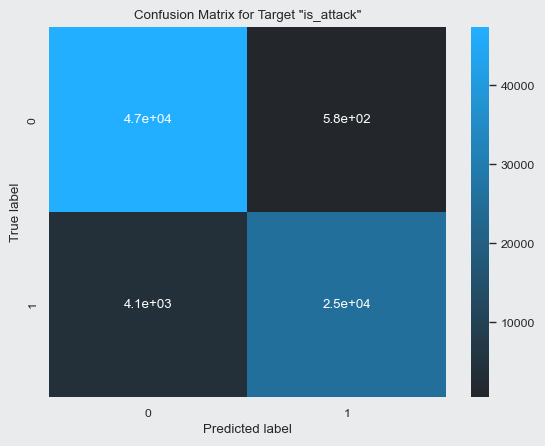

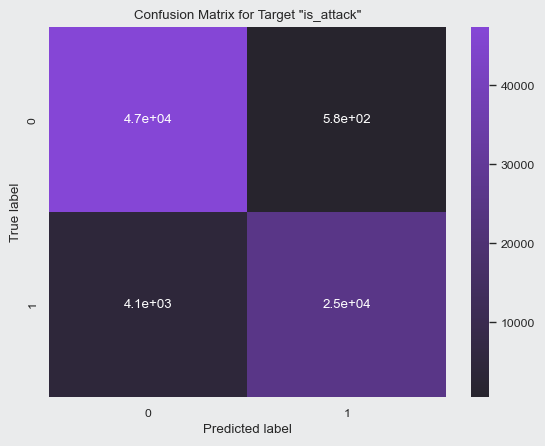

In [34]:
gb_is_attack_pred = gb_is_attack_grid_search.predict(X_test_is_attack)
simple_confusion_matrix(y_true_is_attack, gb_is_attack_pred, 'is_attack')

In [37]:
gb_result_attack_group = evaluate_hpt(
    model=gb_attack_group_grid_search,
    X_test=X_test_attack_group,
    y_true=y_true_attack_group
)

-- Training Results --
Best Parameters:
	learning_rate:	1.5
	max_depth:	10
	n_estimators:	10
	random_state:	404
Best Score:
	0.845248

-- Testing Results --
Accuracy    on Verification Data:	0.911022
Fbeta scroe on Verification Data:	0.911036

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     23747
           2       0.64      0.84      0.73      3041
           3       0.85      0.65      0.74      2533
           4       0.06      0.21      0.09        57

    accuracy                           0.91     29378
   macro avg       0.63      0.66      0.63     29378
weighted avg       0.92      0.91      0.91     29378

False negatives: 366 (12.036% out of 3041 attacks, 1.246% overall)



In [38]:
gb_result_attack_group = evaluate_hpt(
    model=gb_attack_group_grid_search,
    X_test=X_test_attack_group,
    y_true=y_true_attack_group,
    average='macro'
)

-- Training Results --
Best Parameters:
	learning_rate:	1.5
	max_depth:	10
	n_estimators:	10
	random_state:	404
Best Score:
	0.845248

-- Testing Results --
Accuracy    on Verification Data:	0.911022
Fbeta scroe on Verification Data:	0.660937

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     23747
           2       0.64      0.84      0.73      3041
           3       0.85      0.65      0.74      2533
           4       0.06      0.21      0.09        57

    accuracy                           0.91     29378
   macro avg       0.63      0.66      0.63     29378
weighted avg       0.92      0.91      0.91     29378

False negatives: 366 (12.036% out of 3041 attacks, 1.246% overall)



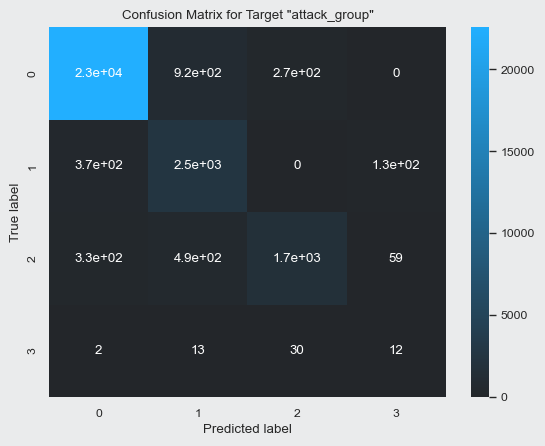

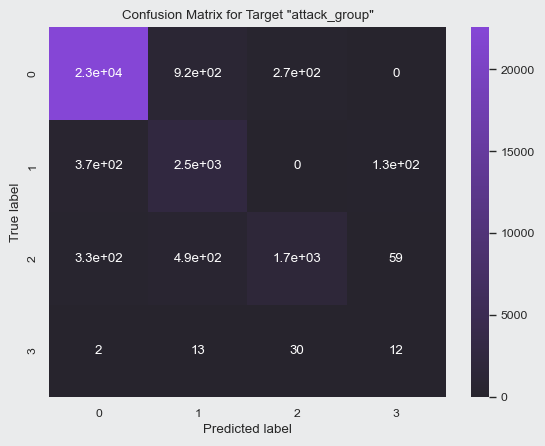

In [39]:
gb_attack_group_pred = gb_attack_group_grid_search.predict(X_test_attack_group)
simple_confusion_matrix(y_true_attack_group, gb_attack_group_pred, 'attack_group')

In [ ]:
BEST_MODEL_IS_ATTACK, BEST_SCORE_IS_ATTACK = compare_models(gb_result_is_attack, rf_result_is_attack)
print()
BEST_MODEL_ATTACK_GROUP, BEST_SCORE_ATTACK_GROUP = compare_models(gb_result_attack_group, rf_result_attack_group)


-- Testing Results --
Accuracy    on Verification Data:	0.937082
Fbeta scroe on Verification Data:	0.848375

              precision    recall  f1-score   support

       False       0.91      0.99      0.95     47913
        True       0.99      0.85      0.91     29378

    accuracy                           0.94     77291
   macro avg       0.95      0.92      0.93     77291
weighted avg       0.94      0.94      0.94     77291



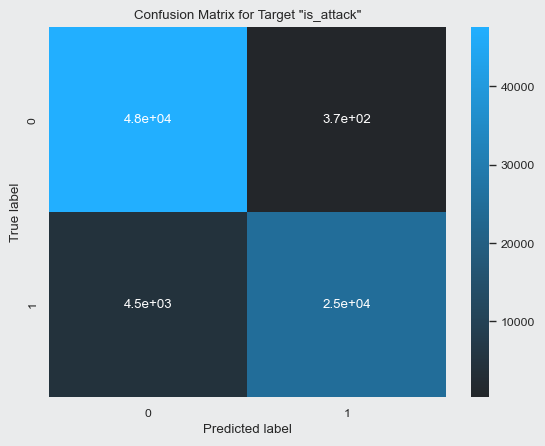

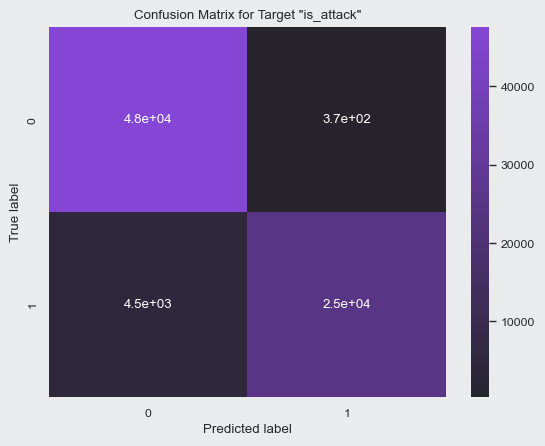

In [ ]:
# Best model on the whole dataset (Attack Detection)
best_gb_is_attack = gb_is_attack_grid_search.best_estimator_.fit(X_train_is_attack, y_train_is_attack)
evaluate_model(best_gb_is_attack, X_test_is_attack, y_true_is_attack, beta=beta, average='binary')
best_gb_is_attack_pred = best_gb_is_attack.predict(X_test_is_attack)
simple_confusion_matrix(y_true_is_attack, best_gb_is_attack_pred, 'is_attack')


-- Testing Results --
Accuracy    on Verification Data:	0.911022
Fbeta scroe on Verification Data:	0.660937

              precision    recall  f1-score   support

           0       0.97      0.95      0.96     23747
           2       0.64      0.84      0.73      3041
           3       0.85      0.65      0.74      2533
           4       0.06      0.21      0.09        57

    accuracy                           0.91     29378
   macro avg       0.63      0.66      0.63     29378
weighted avg       0.92      0.91      0.91     29378



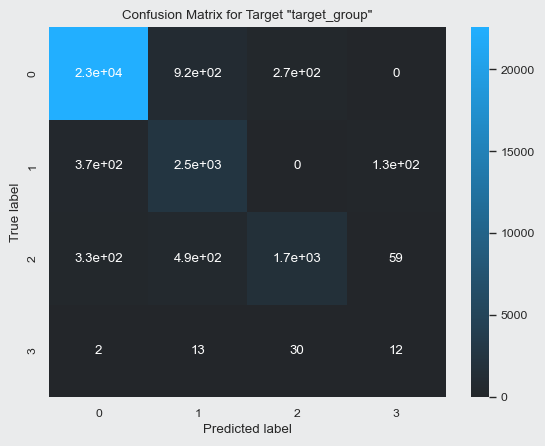

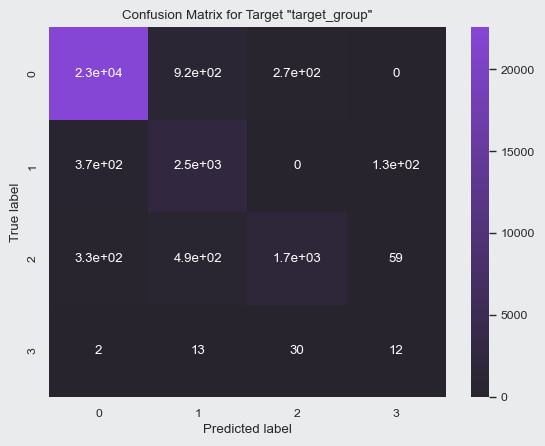

In [41]:
# Best model on the whole dataset (Attack Classification)
best_gb_attack_group = gb_attack_group_grid_search.best_estimator_.fit(X_train_attack_group, y_train_attack_group)
evaluate_model(best_gb_attack_group, X_test_attack_group, y_true_attack_group, beta=beta, average='macro')
best_gb_attack_group_pred = best_gb_attack_group.predict(X_test_attack_group)
simple_confusion_matrix(y_true_attack_group, best_gb_attack_group_pred, 'target_group')

--------------------------------------------------------------------------------

# KNN Hyperparameter Tuning

In [24]:
from sklearn.neighbors import KNeighborsClassifier

In [25]:
knn_param_grid = {
    'n_neighbors': [5, 10, 20, 50, 100],
    'weights': ['uniform', 'distance'],
    'n_jobs': [-1],
}

In [26]:
knn_is_attack_grid_search = hyperparameter_tuning(
    parameter_grid=knn_param_grid,
    base_estimator=KNeighborsClassifier(),
    X_train=X_train_is_attack,
    y_train=y_train_is_attack,
    scoring=f10_scorer
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.995 total time=   2.3s
[CV 2/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.990 total time=   2.1s
[CV 3/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=1.000 total time=   2.1s
[CV 4/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.999 total time=   2.1s
[CV 5/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.991 total time=   2.2s
[CV 1/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.995 total time=   1.0s
[CV 2/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.990 total time=   0.9s
[CV 3/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=1.000 total time=   0.9s
[CV 4/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.999 total time=   0.8s
[CV 5/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.991 total time=   0.9s
[CV 1/5] END n_jobs=-1, n_neighbors=10, weights=unifor

In [27]:
knn_attack_group_grid_search = hyperparameter_tuning(
    parameter_grid=knn_param_grid,
    base_estimator=KNeighborsClassifier(),
    X_train=X_train_attack_group,
    y_train=y_train_attack_group,
    scoring=accuracy_scorer
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.987 total time=   1.0s
[CV 2/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.999 total time=   0.9s
[CV 3/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.994 total time=   1.0s
[CV 4/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.989 total time=   1.0s
[CV 5/5] END n_jobs=-1, n_neighbors=5, weights=uniform;, score=0.784 total time=   1.1s
[CV 1/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.988 total time=   0.4s
[CV 2/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.999 total time=   0.3s
[CV 3/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.994 total time=   0.4s
[CV 4/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.990 total time=   0.4s
[CV 5/5] END n_jobs=-1, n_neighbors=5, weights=distance;, score=0.784 total time=   0.5s
[CV 1/5] END n_jobs=-1, n_neighbors=10, weights=unifor

In [28]:
knn_result_is_attack = evaluate_hpt(
    model=knn_is_attack_grid_search,
    X_test=X_test_is_attack,
    y_true=y_true_is_attack
)

-- Training Results --
Best Parameters:
	n_jobs:	-1
	n_neighbors:	5
	weights:	distance
Best Score:
	0.994959

-- Testing Results --
Accuracy    on Verification Data:	0.931557
Fbeta scroe on Verification Data:	0.931480

              precision    recall  f1-score   support

       False       0.91      0.99      0.95     47913
        True       0.98      0.84      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.93     77291
weighted avg       0.94      0.93      0.93     77291

False negatives: 4707 (16.022% out of 29378 attacks, 6.090% overall)



In [29]:
_ = evaluate_hpt(
    model=knn_is_attack_grid_search,
    X_test=X_test_is_attack,
    y_true=y_true_is_attack,
    average='binary'
)

-- Training Results --
Best Parameters:
	n_jobs:	-1
	n_neighbors:	5
	weights:	distance
Best Score:
	0.994959

-- Testing Results --
Accuracy    on Verification Data:	0.931557
Fbeta scroe on Verification Data:	0.840947

              precision    recall  f1-score   support

       False       0.91      0.99      0.95     47913
        True       0.98      0.84      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.93     77291
weighted avg       0.94      0.93      0.93     77291

False negatives: 4707 (16.022% out of 29378 attacks, 6.090% overall)



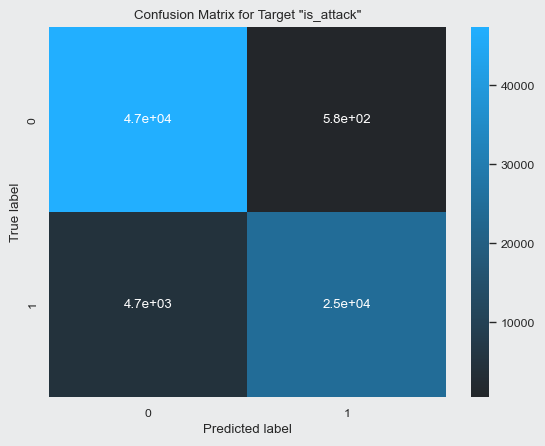

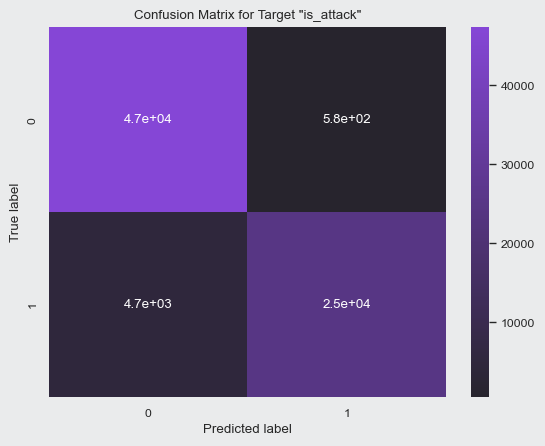

In [30]:
knn_is_attack_pred = knn_is_attack_grid_search.predict(X_test_is_attack)
simple_confusion_matrix(y_true_is_attack, knn_is_attack_pred, 'is_attack')

In [31]:
knn_result_attack_group = evaluate_hpt(
    model=knn_attack_group_grid_search,
    X_test=X_test_attack_group,
    y_true=y_true_attack_group
)

-- Training Results --
Best Parameters:
	n_jobs:	-1
	n_neighbors:	100
	weights:	uniform
Best Score:
	0.977412

-- Testing Results --
Accuracy    on Verification Data:	0.854245
Fbeta scroe on Verification Data:	0.853874

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     23747
           2       0.42      0.67      0.52      3041
           3       0.90      0.18      0.30      2533
           4       0.00      0.00      0.00        57

    accuracy                           0.85     29378
   macro avg       0.57      0.45      0.44     29378
weighted avg       0.88      0.85      0.84     29378

False negatives: 997 (32.785% out of 3041 attacks, 3.394% overall)



/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [32]:
knn_result_attack_group = evaluate_hpt(
    model=knn_attack_group_grid_search,
    X_test=X_test_attack_group,
    y_true=y_true_attack_group,
    average='macro'
)

-- Training Results --
Best Parameters:
	n_jobs:	-1
	n_neighbors:	100
	weights:	uniform
Best Score:
	0.977412

-- Testing Results --
Accuracy    on Verification Data:	0.854245
Fbeta scroe on Verification Data:	0.451001

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     23747
           2       0.42      0.67      0.52      3041
           3       0.90      0.18      0.30      2533
           4       0.00      0.00      0.00        57

    accuracy                           0.85     29378
   macro avg       0.57      0.45      0.44     29378
weighted avg       0.88      0.85      0.84     29378

False negatives: 997 (32.785% out of 3041 attacks, 3.394% overall)



/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

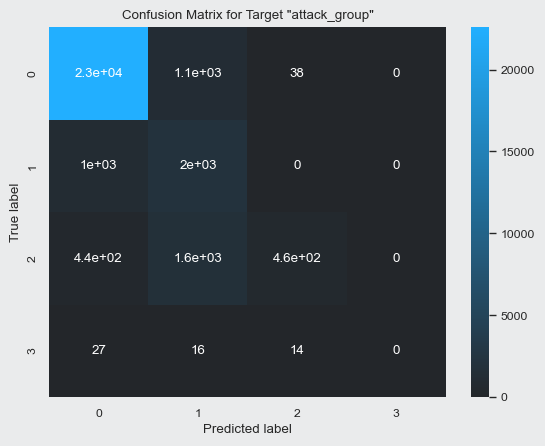

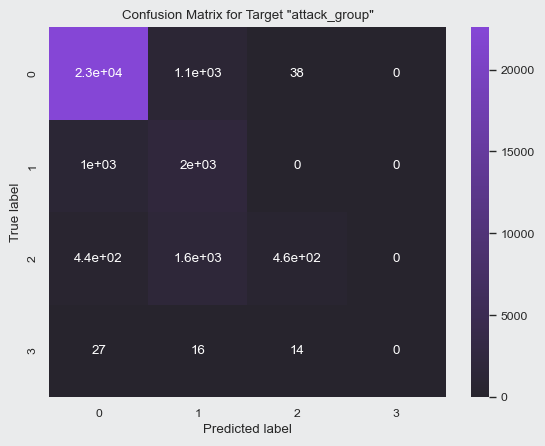

In [33]:
knn_attack_group_pred = knn_attack_group_grid_search.predict(X_test_attack_group)
simple_confusion_matrix(y_true_attack_group, knn_attack_group_pred, 'attack_group')

In [34]:
BEST_MODEL_IS_ATTACK, BEST_SCORE_IS_ATTACK = compare_models(knn_result_is_attack, rf_result_is_attack)
print()
BEST_MODEL_ATTACK_GROUP, BEST_SCORE_ATTACK_GROUP = compare_models(knn_result_attack_group, rf_result_attack_group)

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.006200 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.006197 --> Worsened!

Best model so far:
RandomForestClassifier() with Parameters
{'criterion': 'gini', 'max_depth': 40, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 404}
Its score: 0.937680

-- HPT Evaluation --
new_results.fbeta - old_results.fbeta = -0.159169 --> Worsened!
new_results.accuracy - old_results.accuracy = -0.052522 --> Worsened!

Best model so far:
RandomForestClassifier() with Parameters
{'criterion': 'gini', 'max_depth': 20, 'n_estimators': 20, 'n_jobs': -1, 'random_state': 404}
Its score: 0.610170



-- Testing Results --
Accuracy    on Verification Data:	0.931557
Fbeta scroe on Verification Data:	0.840947

              precision    recall  f1-score   support

       False       0.91      0.99      0.95     47913
        True       0.98      0.84      0.90     29378

    accuracy                           0.93     77291
   macro avg       0.94      0.91      0.93     77291
weighted avg       0.94      0.93      0.93     77291



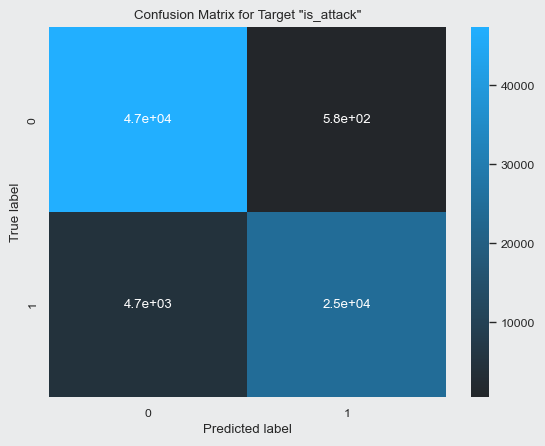

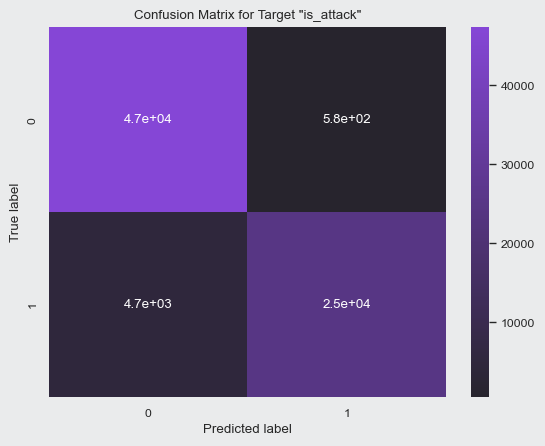

In [62]:
# Best model on the whole dataset (Attack Detection)
best_knn_is_attack = knn_is_attack_grid_search.best_estimator_.fit(X_train_is_attack, y_train_is_attack)
evaluate_model(best_knn_is_attack, X_test_is_attack, y_true_is_attack, beta=beta, average='binary')
best_knn_is_attack_pred = best_knn_is_attack.predict(X_test_is_attack)
simple_confusion_matrix(y_true_is_attack, best_knn_is_attack_pred, 'is_attack')


-- Testing Results --
Accuracy    on Verification Data:	0.854245
Fbeta scroe on Verification Data:	0.451001

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     23747
           2       0.42      0.67      0.52      3041
           3       0.90      0.18      0.30      2533
           4       0.00      0.00      0.00        57

    accuracy                           0.85     29378
   macro avg       0.57      0.45      0.44     29378
weighted avg       0.88      0.85      0.84     29378



/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

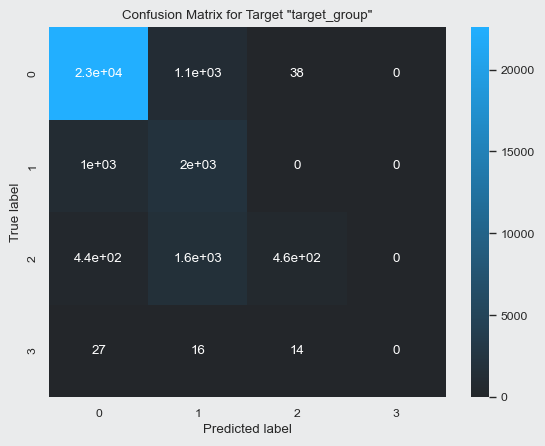

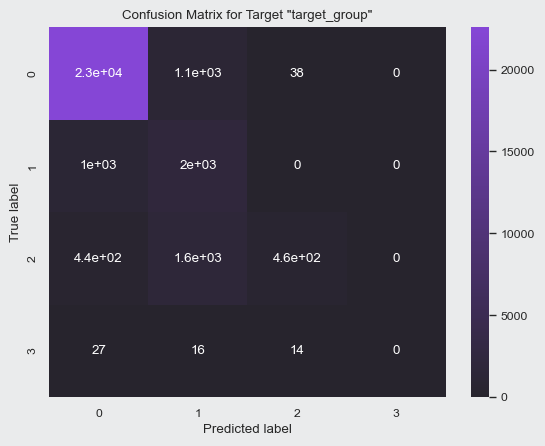

In [63]:
# Best model on the whole dataset (Attack Classification)
best_knn_attack_group = knn_attack_group_grid_search.best_estimator_.fit(X_train_attack_group, y_train_attack_group)
evaluate_model(best_knn_attack_group, X_test_attack_group, y_true_attack_group, beta=beta, average='macro')
best_knn_attack_group_pred = best_knn_attack_group.predict(X_test_attack_group)
simple_confusion_matrix(y_true_attack_group, best_knn_attack_group_pred, 'target_group')

--------------------------------------------------------------------------------

# Logistic Regression Hyperparameter Tuning

In [42]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [43]:
lr_param_grid = {
    'penalty': ['l2', None],
    'tol': [1.e-4, 1.e-5],
    'C': [0.4 + 0.4*n for n in range(3)],
    'fit_intercept': [True, False],
    'max_iter': [10_000],
    'n_jobs': [-1],
    'random_state': [404]
}

In [44]:
lr_is_attack_grid_search = hyperparameter_tuning(
    parameter_grid=lr_param_grid,
    base_estimator=LogisticRegression(),
    X_train=X_train_is_attack,
    y_train=y_train_is_attack,
    scoring=f10_scorer
)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.969 total time=  14.2s
[CV 2/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.964 total time= 1.9min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.995 total time= 2.1min
[CV 4/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.993 total time= 2.1min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.990 total time= 1.7min
[CV 1/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.969 total time=  13.0s
[CV 2/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.964 total time= 2.0min
[CV 3/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.995 total time= 2.1min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.993 total time= 2.1min
[CV 5/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.990 total time= 1.7min
[CV 1/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.966 total time=   6.0s
[CV 2/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.963 total time= 1.9min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.995 total time= 2.1min
[CV 4/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.993 total time= 2.1min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.990 total time= 2.1min
[CV 1/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=1e-05;, score=0.966 total time=   6.2s
[CV 2/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=1e-05;, score=0.963 total time= 1.9min
[CV 3/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=1e-05;, score=0.995 total time= 2.1min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=1e-05;, score=0.993 total time= 2.1min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=1e-05;, score=0.990 total time= 2.1min
[CV 1/5] END C=0.4, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.964 total time=   8.8s
[CV 2/5] END C=0.4, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.963 total time=  32.9s


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=0.4, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.995 total time= 2.1min
[CV 4/5] END C=0.4, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.992 total time= 1.0min
[CV 5/5] END C=0.4, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.990 total time= 1.2min
[CV 1/5] END C=0.4, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.964 total time=   8.8s
[CV 2/5] END C=0.4, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.963 total time=  32.1s


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=0.4, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.995 total time= 2.1min
[CV 4/5] END C=0.4, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.992 total time= 1.0min
[CV 5/5] END C=0.4, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.990 total time= 1.2min
[CV 1/5] END C=0.4, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.968 total time=  22.9s
[CV 2/5] END C=0.4, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.963 total time= 1.0min
[CV 3/5] END C=0.4, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.995 total time=  56.5s
[CV 4/5] END C=0.4, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.992 total time= 1.0min
[

/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.965 total time= 2.1min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.996 total time= 2.1min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.993 total time= 2.1min
[CV 5/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.990 total time=  48.9s
[CV 1/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.969 total time=  10.8s


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.965 total time= 2.0min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.996 total time=33.1min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.993 total time=33.1min
[CV 5/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.990 total time=17.7min
[CV 1/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.966 total time=   7.0s
[CV 2/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.963 total time=35.6min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.995 total time=42.3min
[CV 4/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.993 total time=22.1min
[CV 5/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.990 total time= 2.1min
[CV 1/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=1e-05;, score=0.966 total time=   6.7s
[CV 2/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=1e-05;, score=0.963 total time= 1.8min
[CV 3/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=1e-05;, score=0.995 total time= 2.1min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=1e-05;, score=0.993 total time= 2.1min
[CV 5/5] END C=0.8, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=1e-05;, score=0.990 total time= 2.1min
[CV 1/5] END C=0.8, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.968 total time=   9.7s
[CV 2/5] END C=0.8, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.963 total time= 1.2min
[CV 3/5] END C=0.8, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.995 total time= 1.6min
[CV 4/5] END C=0.8, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.992 total time=  30.8s
[CV 5/5] END C=0.8, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.990 total time= 1.4min
[CV 1/

/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.964 total time= 2.1min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.995 total time= 2.1min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.993 total time= 2.1min
[CV 5/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.990 total time= 1.3min
[CV 1/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.969 total time=  20.6s


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.964 total time= 2.1min
[CV 3/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.995 total time= 2.1min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.993 total time= 2.1min
[CV 5/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.990 total time= 1.3min
[CV 1/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.966 total time=   6.0s
[CV 2/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.963 total time= 1.9min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.995 total time= 2.1min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.993 total time= 2.1min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.990 total time= 2.1min
[CV 1/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=1e-05;, score=0.966 total time=   6.1s
[CV 2/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=1e-05;, score=0.963 total time= 1.9min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=1e-05;, score=0.995 total time= 2.1min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=1e-05;, score=0.993 total time= 2.1min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=1e-05;, score=0.990 total time=18.2min
[CV 1/5] END C=1.2000000000000002, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.967 total time=  12.5s
[CV 2/5] END C=1.2000000000000002, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.963 total time=43.4min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=1.2000000000000002, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.995 total time=35.8min
[CV 4/5] END C=1.2000000000000002, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.992 total time=18.1min
[CV 5/5] END C=1.2000000000000002, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.990 total time=22.2min
[CV 1/5] END C=1.2000000000000002, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.967 total time=  12.7s
[CV 2/5] END C=1.2000000000000002, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.963 total time= 2.0min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=1.2000000000000002, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.995 total time= 2.0min
[CV 4/5] END C=1.2000000000000002, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.992 total time= 1.0min
[CV 5/5] END C=1.2000000000000002, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.990 total time= 2.1min
[CV 1/5] END C=1.2000000000000002, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.968 total time=  22.8s
[CV 2/5] END C=1.2000000000000002, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.963 total time= 1.0min
[CV 3/5] END C=1.2000000000000002, fit_intercept=False, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.995 total time=  56.4s
[CV 4/5] END C=1.2000000000000002, fit_intercept=False,

In [45]:
lr_attack_group_grid_search = hyperparameter_tuning(
    parameter_grid=lr_param_grid,
    base_estimator=LogisticRegression(),
    X_train=X_train_attack_group,
    y_train=y_train_attack_group,
    scoring=accuracy_scorer
)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.965 total time=  24.3s
[CV 2/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.979 total time=  56.8s
[CV 3/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.970 total time= 2.8min
[CV 4/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.977 total time=  27.7s
[CV 5/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.217 total time=  41.5s
[CV 1/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.965 total time=  24.4s
[CV 2/5] END C=0.4, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=4

/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.964 total time=16.3min
[CV 4/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.978 total time=15.9min
[CV 5/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=0.0001;, score=0.216 total time=17.9min
[CV 1/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.972 total time=  38.6s
[CV 2/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.969 total time=66.0min


/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.964 total time=27.9min
[CV 4/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.978 total time=  24.4s
[CV 5/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=l2, random_state=404, tol=1e-05;, score=0.216 total time=17.6min
[CV 1/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.967 total time=16.5min
[CV 2/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.965 total time=  49.1s
[CV 3/5] END C=1.2000000000000002, fit_intercept=True, max_iter=10000, n_jobs=-1, penalty=None, random_state=404, tol=0.0001;, score=0.961 total time=18.0min
[CV 4/5] END C=1.2000000000000002, fit_intercept=True, max_it

In [46]:
lr_result_is_attack = evaluate_hpt(
    model=lr_is_attack_grid_search,
    X_test=X_test_is_attack,
    y_true=y_true_is_attack
)

-- Training Results --
Best Parameters:
	C:	0.8
	fit_intercept:	True
	max_iter:	10000
	n_jobs:	-1
	penalty:	l2
	random_state:	404
	tol:	0.0001
Best Score:
	0.982690

-- Testing Results --
Accuracy    on Verification Data:	0.913056
Fbeta scroe on Verification Data:	0.912941

              precision    recall  f1-score   support

       False       0.89      0.98      0.93     47913
        True       0.96      0.80      0.87     29378

    accuracy                           0.91     77291
   macro avg       0.93      0.89      0.90     77291
weighted avg       0.92      0.91      0.91     77291

False negatives: 5866 (19.967% out of 29378 attacks, 7.589% overall)



In [47]:
_ = evaluate_hpt(
    model=lr_is_attack_grid_search,
    X_test=X_test_is_attack,
    y_true=y_true_is_attack,
    average='binary'
)

-- Training Results --
Best Parameters:
	C:	0.8
	fit_intercept:	True
	max_iter:	10000
	n_jobs:	-1
	penalty:	l2
	random_state:	404
	tol:	0.0001
Best Score:
	0.982690

-- Testing Results --
Accuracy    on Verification Data:	0.913056
Fbeta scroe on Verification Data:	0.801681

              precision    recall  f1-score   support

       False       0.89      0.98      0.93     47913
        True       0.96      0.80      0.87     29378

    accuracy                           0.91     77291
   macro avg       0.93      0.89      0.90     77291
weighted avg       0.92      0.91      0.91     77291

False negatives: 5866 (19.967% out of 29378 attacks, 7.589% overall)



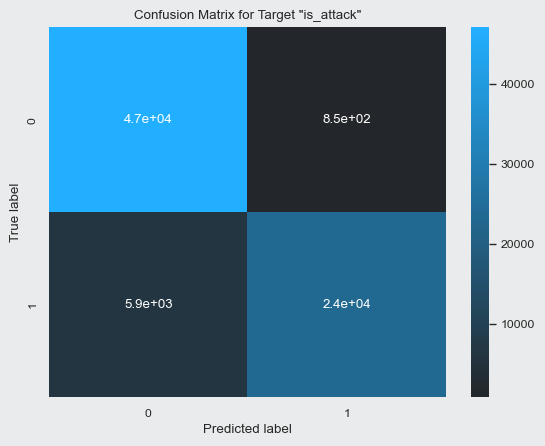

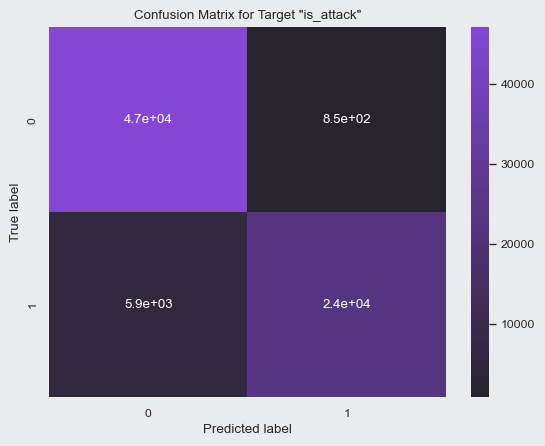

In [48]:
lr_is_attack_pred = lr_is_attack_grid_search.predict(X_test_is_attack)
simple_confusion_matrix(y_true_is_attack, lr_is_attack_pred, 'is_attack')

In [49]:
lr_result_attack_group = evaluate_hpt(
    model=lr_attack_group_grid_search,
    X_test=X_test_attack_group,
    y_true=y_true_attack_group
)

-- Training Results --
Best Parameters:
	C:	0.4
	fit_intercept:	False
	max_iter:	10000
	n_jobs:	-1
	penalty:	l2
	random_state:	404
	tol:	0.0001
Best Score:
	0.826883

-- Testing Results --
Accuracy    on Verification Data:	0.882565
Fbeta scroe on Verification Data:	0.882014

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     23747
           2       0.70      0.56      0.62      3041
           3       0.86      0.25      0.39      2533
           4       0.00      0.00      0.00        57

    accuracy                           0.88     29378
   macro avg       0.62      0.45      0.49     29378
weighted avg       0.87      0.88      0.86     29378

False negatives: 1324 (43.538% out of 3041 attacks, 4.507% overall)



In [50]:
_ = evaluate_hpt(
    model=lr_attack_group_grid_search,
    X_test=X_test_attack_group,
    y_true=y_true_attack_group
)

-- Training Results --
Best Parameters:
	C:	0.4
	fit_intercept:	False
	max_iter:	10000
	n_jobs:	-1
	penalty:	l2
	random_state:	404
	tol:	0.0001
Best Score:
	0.826883

-- Testing Results --
Accuracy    on Verification Data:	0.882565
Fbeta scroe on Verification Data:	0.882014

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     23747
           2       0.70      0.56      0.62      3041
           3       0.86      0.25      0.39      2533
           4       0.00      0.00      0.00        57

    accuracy                           0.88     29378
   macro avg       0.62      0.45      0.49     29378
weighted avg       0.87      0.88      0.86     29378

False negatives: 1324 (43.538% out of 3041 attacks, 4.507% overall)



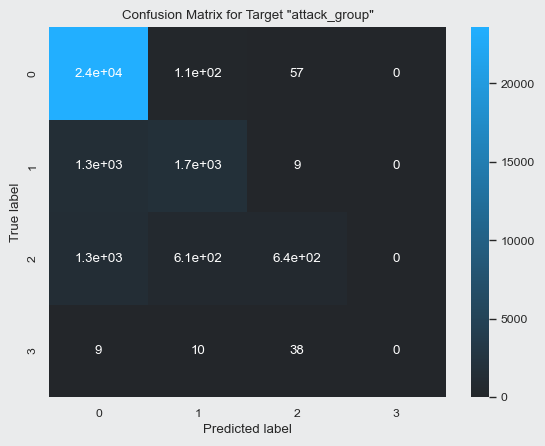

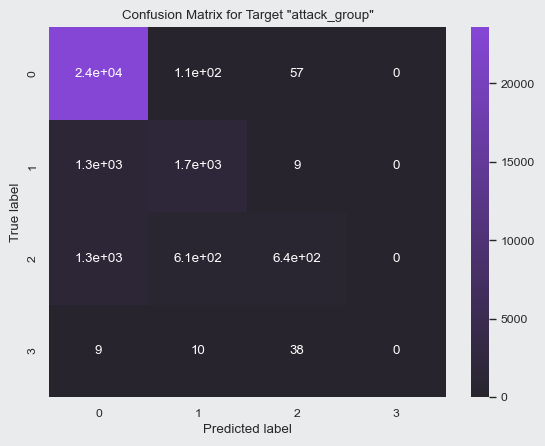

In [51]:
lr_attack_group_pred = lr_attack_group_grid_search.predict(X_test_attack_group)
simple_confusion_matrix(y_true_attack_group, lr_attack_group_pred, 'attack_group')

In [ ]:
BEST_MODEL_IS_ATTACK, BEST_SCORE_IS_ATTACK = compare_models(lr_result_is_attack, knn_result_is_attack)
print()
BEST_MODEL_ATTACK_GROUP, BEST_SCORE_ATTACK_GROUP = compare_models(lr_result_attack_group, rf_result_attack_group)

/Users/wolf/0-Projects/Your-Data-Is-Mine/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



-- Testing Results --
Accuracy    on Verification Data:	0.913056
Fbeta scroe on Verification Data:	0.801681

              precision    recall  f1-score   support

       False       0.89      0.98      0.93     47913
        True       0.96      0.80      0.87     29378

    accuracy                           0.91     77291
   macro avg       0.93      0.89      0.90     77291
weighted avg       0.92      0.91      0.91     77291



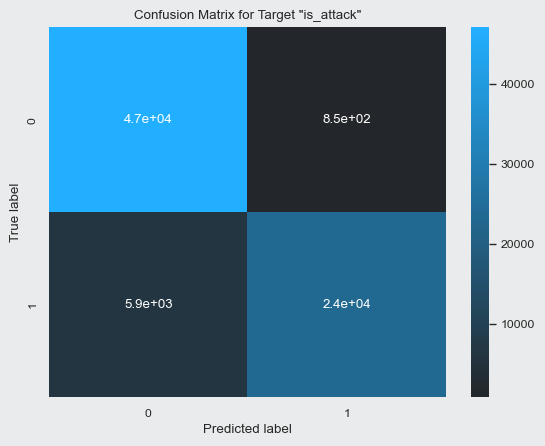

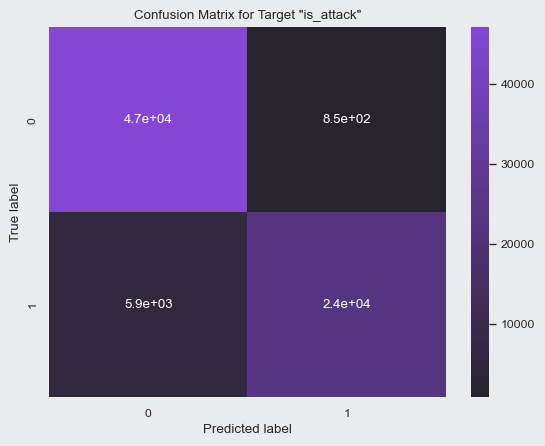

In [52]:
# Best model on the whole dataset (Attack Detection)
best_lr_is_attack = lr_is_attack_grid_search.best_estimator_.fit(X_train_is_attack, y_train_is_attack)
evaluate_model(best_lr_is_attack, X_test_is_attack, y_true_is_attack, beta=beta, average='binary')
best_lr_is_attack_pred = best_lr_is_attack.predict(X_test_is_attack)
simple_confusion_matrix(y_true_is_attack, best_lr_is_attack_pred, 'is_attack')


-- Testing Results --
Accuracy    on Verification Data:	0.882565
Fbeta scroe on Verification Data:	0.452291

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     23747
           2       0.70      0.56      0.62      3041
           3       0.86      0.25      0.39      2533
           4       0.00      0.00      0.00        57

    accuracy                           0.88     29378
   macro avg       0.62      0.45      0.49     29378
weighted avg       0.87      0.88      0.86     29378



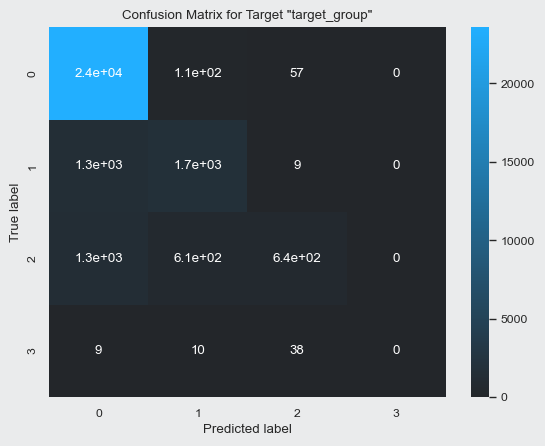

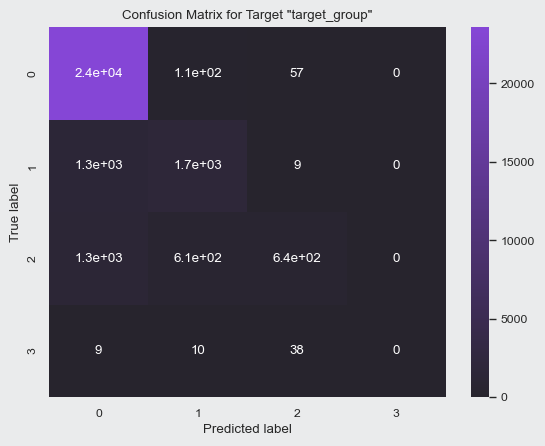

In [53]:
# Best model on the whole dataset (Attack Classification)
best_lr_attack_group = lr_attack_group_grid_search.best_estimator_.fit(X_train_attack_group, y_train_attack_group)
evaluate_model(best_lr_attack_group, X_test_attack_group, y_true_attack_group, beta=beta, average='macro')
best_lr_attack_group_pred = best_lr_attack_group.predict(X_test_attack_group)
simple_confusion_matrix(y_true_attack_group, best_lr_attack_group_pred, 'target_group')